In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from tensorflow.contrib.data import Dataset, Iterator
import time
from datetime import timedelta, datetime

/home/alcaster/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10045259050866694879, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3501326336
 locality {
   bus_id: 1
 }
 incarnation: 16580545396035454071
 physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"]

In [14]:
sess = tf.Session()
lr = 1e-3
batch_size = 128
epochs = 50

In [4]:
(train_x, train_y), (test_x, test_y) = load_data()

In [5]:
NUM_CLASSES = len(np.unique(train_y))
IMAGE_SIZE = 32
CHANNELS = 3
img_size_flat = IMAGE_SIZE*IMAGE_SIZE*CHANNELS

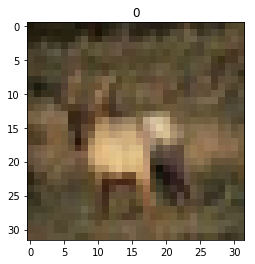

In [6]:
plt.imshow(train_x[3])
plt.title('%i' % np.argmax(train_y[3])); plt.show()

In [7]:
def input_parser(img, label):
  label = tf.reshape(label, [-1])
  one_hot = tf.one_hot(label, (NUM_CLASSES)) # [5000, 100]
  one_hot = tf.reshape(one_hot, [-1])
  img /= 255
  return img, one_hot

In [8]:
train_dataset = Dataset.from_tensor_slices((train_x, train_y)).map(input_parser).repeat(epochs).batch(batch_size)
valid_dataset = Dataset.from_tensor_slices((test_x, test_y)).map(input_parser).repeat().batch(batch_size)

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()

# make datasets that we can initialize separately, but using the same structure via the common iterator
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(valid_dataset)

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.


In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)


    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    return layer_flat, num_features
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [10]:
x, y = iterator.get_next()
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x,
                   num_input_channels=CHANNELS,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=NUM_CLASSES,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
prediction = tf.argmax(y, 1)
correct_prediction = tf.equal(y_pred_cls, prediction)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init_op = tf.global_variables_initializer()

In [11]:
def validate(sess):
    valid_iters = 100
    sess.run(validation_init_op)
    avg_acc = 0
    for i in range(valid_iters):
        acc = sess.run([accuracy])
        avg_acc += acc[0]
    print("Average validation set accuracy over {} iterations is {:.2f}%".format(valid_iters,(avg_acc / valid_iters) * 100))

In [12]:
total_iterations = 0

def optimize():
    global total_iterations
    num_iterations = 0
    start_time = time.time()

    with tf.Session() as sess:
      sess.run(init_op)
      sess.run(training_init_op)
      saver = tf.train.Saver()

      while(True):
          try:
            sess.run(optimizer)
          except tf.errors.OutOfRangeError:
            break

          if num_iterations % 100 == 0:
              l, _, acc = sess.run([loss, optimizer, accuracy])
              print("Batch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(num_iterations, l, acc * 100))
          num_iterations+=1
      total_iterations += num_iterations

      time_dif = time.time() - start_time
      print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
      validate(sess)
#       save_path = saver.save(sess, "data/checkpoint-{}.ckpt".format(datetime.now().isoformat()))
#       print('done saving at',save_path)

In [13]:
optimize()

Batch: 0, loss: 2.321, training accuracy: 8.59%
Batch: 100, loss: 1.757, training accuracy: 37.50%
Batch: 200, loss: 1.349, training accuracy: 46.88%
Batch: 300, loss: 1.454, training accuracy: 45.31%
Batch: 400, loss: 1.316, training accuracy: 55.47%
Batch: 500, loss: 1.383, training accuracy: 53.12%
Batch: 600, loss: 1.352, training accuracy: 45.31%
Batch: 700, loss: 1.171, training accuracy: 63.28%
Time usage: 0:00:27
Average validation set accuracy over 100 iterations is 57.77%


NameError: name 'save_path' is not defined

In [ ]:
import os
print(os.getcwd())
print(os.listdir('data'))

/content
['checkpoint-2018-03-20T21:18:23.994098.ckpt.data-00000-of-00001', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.meta', 'checkpoint-2018-03-20T21:18:23.994098.ckpt.meta', 'checkpoint1.ckpt.meta', 'checkpoint1.ckpt.data-00000-of-00001', 'checkpoint-2018-03-20T21:18:23.994098.ckpt.index', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.index', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.data-00000-of-00001', 'checkpoint1.ckpt.index', 'checkpoint']


In [ ]:
from google.colab import files
for file in ['checkpoint-2018-03-20T21:18:23.994098.ckpt.data-00000-of-00001', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.meta', 'checkpoint-2018-03-20T21:18:23.994098.ckpt.meta', 'checkpoint1.ckpt.meta', 'checkpoint1.ckpt.data-00000-of-00001', 'checkpoint-2018-03-20T21:18:23.994098.ckpt.index', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.index', 'checkpoint-2018-03-20T21:43:11.610030.ckpt.data-00000-of-00001', 'checkpoint1.ckpt.index', 'checkpoint']:
  files.download("data/"+file)

KeyboardInterrupt: ignored